A raspberry pi project, inspired by [tjaap](https://www.instructables.com/Literary-Clock-Made-From-E-reader/). This python notebook is looking at the basics - how to get the data, parse it, display a quote, then moves on to create a repo and put the code onto the actual hardware.

The primary source for quotes is the [guardian's user provided list](https://www.theguardian.com/books/table/2011/apr/21/literary-clock). This list is incomplete, and the guardian put up a bigger list in 2014 as a gsheet but thats no longer avaiable, so I found a more complete quotes list on [github](https://github.com/JohannesNE/literature-clock/tree/master).

First up, making a list of times to check for missing times:

In [97]:
# | echo: false
import os
import re
import sys
import json
import requests
import random
import time  # https://docs.python.org/3/library/time.html
from datetime import datetime, timezone, timedelta

from dataclasses import dataclass
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [153]:
# a list containiner all 1,440 times
times = [f"{hour:02}:{minute:02}" for hour in range(24) for minute in range(60)]
assert len(times) == 60 * 24  # check for all 1,440 clock times
print(times[55:65])  # check it looks good

['00:55', '00:56', '00:57', '00:58', '00:59', '01:00', '01:01', '01:02', '01:03', '01:04']


## The literary quotes

I initial looked at the list of quotes on the guardian website from 2011, but that was really incomplete, so after some internet kungfu I moved on to a better [list of quotes maintained here](https://github.com/JohannesNE/literature-clock).

That project already implements a literary clock, but ignoring that to make my own, here goes:

In [154]:
url = "https://raw.githubusercontent.com/JohannesNE/literature-clock/master/litclock_annotated.csv"

df = pd.read_csv(
    url, sep="|", names=["time", "annot", "quote", "title", "author", "nsfw"]
)

df.sample(4)

,time,annot,quote,title,author,nsfw
2854,22:00,ten,"By ten, Quoyle was drunk. The crowd was enormo...",The Shipping News,E. Annie Proulx,unknown
210,01:30,1:30 A.M.,Around 1:30 A.M. the door opened and I thought...,Microserfs,Douglas Coupland,unknown
1596,12:00,Noon,The Birds begun at Four o'clock<br/>Their peri...,The Birds Begun at Four o'clock,Emily Dickinson,unknown
1878,14:31,thirty-one minutes past two,Igor checked the time again. He didn't really;...,The Vampire's Treaty,Matt Shaw,sfw


Some basic data checks:

21 time values missing: ['02:49', '03:24', '06:03', '06:07', '06:18', '06:47', '07:41', '08:21', '10:28', '11:16', '11:46', '12:31', '13:19', '13:36', '14:23', '15:31', '17:46', '18:14', '18:44', '21:06', '21:14']

886 times have exactly 1 quote, 533 times have more than 1 quote.


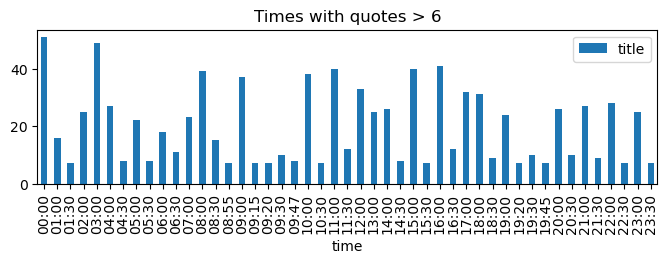

In [158]:
missing_times = [time for time in times if time not in df.time.values]
print(f"{len(missing_times)} time values missing: {missing_times}")

single_quote = sum(df.groupby("time").count().title == 1)
multiple_quotes = sum(df.groupby("time").count().title > 1)

print(
    f"\n{single_quote} times have exactly 1 quote, {multiple_quotes} times have more than 1 quote."
)

ax = (
    df[["time", "title"]]
    .groupby("time")
    .count()[df.groupby("time").count().title > 6]
    .plot.bar(title="Times with quotes > 6", figsize=(8, 2))
)

So we now have a dataframe full of quotes. I'll deal with the 21 missing quotes later.

The gthub repo produced a folder full of json files, one for each time stamp, so I could just re-use that, but whats the fun of that. 

### Spliting up quotes

Ideally, we want the current time in the quote highlighted. The csv file has a col `annot` which is the time part of the quote string. Initially I tried to use regex to split the string, but since the time is in so many different formats it has to be done manually, hence the `annot` col.

The time can contain special characters like `[]` so [re.escape](https://docs.python.org/3/library/re.html?highlight=escape#re.escape) fixes that. I had to use re.split instead of str.split here as only re.split has a ignorecase feature.

In [159]:
def split_quote(row):
    """adds a prefix and suffix to the quote."""
    prefix, suffix = re.split(
        re.escape(row.annot), row.quote, maxsplit=1, flags=re.IGNORECASE
    )
    row["prefix"] = prefix
    row["suffix"] = suffix
    return row


df = df.apply(split_quote, axis=1)
df.sample(3)

,time,annot,quote,title,author,nsfw,prefix,suffix
2453,19:00,seven o’clock,"“Yes, seven o’clock. I will bring dessert.” Sm...",The Catacombs,Jeremy Bates,unknown,"“Yes,",. I will bring dessert.” Smiling in her sad-ha...
612,05:00,five in the morning,I did Danièle’s math in my head. “If we start ...,The Catacombs,Jeremy Bates,unknown,I did Danièle’s math in my head. “If we start ...,". Seven hours back, it won’t be noon until we ..."
685,05:42,eighteen minutes to six,"At eighteen minutes to six, they blew the wall...",A Gentleman's Game,Greg Rucka,sfw,At,", they blew the wall, and even then, it was al..."


I can now display the quote with the time highlighted, an example below in markdown format:

In [161]:
row = df.iloc[100]
f"{row.prefix}**{row.annot}**{row.suffix}"

'It was **half-past twelve** when I returned to the Albany as a last desperate resort. The scene of my disaster was much as I had left it. The baccarat-counters still strewed the table, with the empty glasses and the loaded ash-trays. A window had been opened to let the smoke out, and was letting in the fog instead.'

### Saving quotes to disk

First up, saving a single json object containing all the quotes, which is easy to use:

In [176]:
# returns a string representing the json
quotes_json = df.groupby("time").agg(list).to_json(orient="index")

# writes the json to disk
df.groupby("time").agg(list).to_json("quotes.json", orient="index", compression=None)

# read the quotes from disk
with open("quotes.json", "r") as f:
    quotes = json.load(f)

print(f"{len(quotes):,} keys which look like: {list(quotes.keys())[40:44]}")
quotes["01:40"]

1,419 keys which look like: ['00:40', '00:41', '00:42', '00:43']


{'annot': ['one-forty am'],
 'quote': ['March twelfth, one-forty am, she leaves a group of drinking buddies to catch a bus home. She never makes it.'],
 'title': ['Bones to Ashes'],
 'author': ['Kathy Reichs'],
 'nsfw': ['unknown'],
 'prefix': ['March twelfth, '],
 'suffix': [', she leaves a group of drinking buddies to catch a bus home. She never makes it.']}

### Save each minute as a seperate file

I'm using a raspberry pi pico w, it doesn't have enough memory to contain the ~2k quotes. So I'm going to write a json file for every minute, and open and close each file as needed.

I'm keeping only the columns needed to save on diskspace:

In [186]:
for key in df.time.unique():
    df[["time", "annot", "prefix", "suffix", "title", "author"]].query(
        "time==@key"
    ).groupby("time").agg(list).to_json(f"quotes/{key}.json", orient="index")

# Checking the total size of the many quote files
quotes_size = (
    sum([os.path.getsize(f"quotes/{f}") for f in os.listdir("quotes")]) / 10**3
)
f"{len(os.listdir('quotes')):,} json files total {quotes_size:.2f}kb"

'1,419 json files total 931.76kb'

I can compress these to save further on space, which I'll get to later if needed. Its nice to have a human readable json string rather than a binary object on the pico for future poking around.

## Get current time and display quote

Micropython has a [time](https://docs.micropython.org/en/latest/library/time.html) module, which is a subset of the [built in python time library](https://docs.python.org/3/library/time.html). The pi's clock needs to be synced on boot with a timeserver, leaving that for the future...

Right now, I get the current time, than open the json file for that timestamp, select a random quote from it and return it.

In [217]:
def get_time():
    """returns current time in 00:00 format"""
    time_now = time.localtime()
    return f"{time_now.tm_hour}:{time_now.tm_min}"


def get_quote(time_str=None):
    """returns a dict containing a single quote for a given time"""
    if time_str is None:
        time_str = get_time()

    # open json file
    with open(f"quotes/{time_str}.json", "r") as f:
        quote = json.load(f)[time_str]

    i = random.randint(0, len(quote["title"]) - 1)
    return {key: quote[key][i] for key in quote.keys()}


quote = get_quote()
print(f"quote dict keys: {quote.keys()}")
print(f"\n{quote['prefix']}**{quote['annot']}**{quote['suffix']}")
f"{quote['title']} by {quote['author']}"

quote dict keys: dict_keys(['annot', 'prefix', 'suffix', 'title', 'author'])

It was now **eight minutes to eleven**, and he began to feel rather cross and impatient. There was nothing to do in the big, ugly, stately room into which he had been shown.


'From Out of the Vasty Deep by Marie Belloc Lowndes'

That seems to be working well, so now I should be able to assemble the pieces and display this on a raspberry pico display.

## Raspberry Pi Pico

Allright, now that I have the basics ready to go, here goes putting this on a pi pico. First up, we need a github repo. 

## Misc

Things not needed anymore, left in case they are useful in the future.

### Guardian quotes from 2011

Guardian clock quotes from 2011, left below as a pandas exercise in fetching a table from a html page and some basic transformations to be able to use it.

In [677]:
clock_url = "https://www.theguardian.com/books/table/2011/apr/21/literary-clock"

df_quotes = (
    pd.read_html(clock_url)[0]  # get first table
    .rename(
        columns={
            "Time of quote": "time",
            "Quote": "quote",
            "Title of book": "title",
            "Author": "author",
        }
    )
    .sort_values(by="time")
    .drop(columns=["Your username"])  # no need for this col
    .dropna(subset=["quote"])  # drop blank rows at end
)

# fix some wonky time strings
df_quotes.time = df_quotes.time.str.replace(".", ":")

print(f"{df_quotes.shape} quotes, so missing a lot!")
df_quotes.sample(2)

(935, 4) quotes, so missing a lot!


,time,quote,title,author
204,07:10:00h,A search in Bradshaw informed me that a train ...,The 39 Steps,John Buchan
409,11:15:00h,The first time I saw them it was around eleven...,Where I'm Calling From,Raymond Carver


There is a 2014 Guardlian list, but looks like that was a google sheet which they have now taken down.